In [1]:
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics, ensemble, decomposition
from sklearn.model_selection import GridSearchCV

%matplotlib inline 
np.random.seed(742390)


In [2]:
data = pd.read_csv(f'Penguins.csv').rename(columns={'Unnamed: 0': 'Index'}).set_index('Index')
data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
Index,,,,,,,
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [3]:
pd.isna(data).value_counts()

species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  sex  
False    False   False             False            False              False        False    301
                                                    True               False        False     33
                                                    False              False        True       7
                 True              True             True               True         True       2
                 False             False            True               False        True       1
dtype: int64

In [4]:
#eliminamos las entradas con mas de un NaN
data = data.dropna(thresh=6)
pd.isna(data).value_counts()

species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  sex  
False    False   False             False            False              False        False    301
                                                    True               False        False     33
                                                    False              False        True       7
dtype: int64

In [5]:
values = ('Adelie', 'Chinstrap', 'Gentoo')
species_translator = {}
for i, k in enumerate(values):
    species_translator[k] = i+1
    species_translator[i+1] = i+1

In [6]:
values = set(data['island']).difference(set(['.', np.nan]))
island_translator = {}
for i, k in enumerate(values):
    island_translator[k] = i+1
    island_translator[i+1] = i+1

In [7]:
values = set(data['sex']).difference(set(['.', np.nan]))
sex_translator = {}
for i, k in enumerate(values):
    sex_translator[k] = i+1
    sex_translator[i+1] = i+1
    
sex_translator[np.nan] = np.nan
sex_translator['.'] = np.nan

In [8]:
data['species'] = data['species'].apply(lambda x: species_translator[x])
data['island'] = data['island'].apply(lambda x: island_translator[x])
data['sex'] = data['sex'].apply(lambda x: sex_translator[x])

pd.isna(data).value_counts()

species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  sex  
False    False   False             False            False              False        False    300
                                                    True               False        False     33
                                                    False              False        True       8
dtype: int64

In [9]:
reg_data = data[data['flipper_length_mm'].notnull()]
flipper_reg = sk.tree.DecisionTreeRegressor().fit(reg_data[['culmen_length_mm','culmen_depth_mm']], reg_data['flipper_length_mm'])
flipper_reg.score(reg_data[['culmen_length_mm','culmen_depth_mm']], reg_data['flipper_length_mm'])

0.9957469947009107

In [10]:
reg_data = data[data['sex'].notnull()]
sex_reg = sk.tree.DecisionTreeRegressor().fit(reg_data[['species', 'body_mass_g', 'culmen_length_mm','culmen_depth_mm']], reg_data['sex'])
sex_reg.score(reg_data[['species', 'body_mass_g', 'culmen_length_mm','culmen_depth_mm']], reg_data['sex'])

1.0

In [11]:
for i in data.index.values:
    if data.loc[i, ['flipper_length_mm']].isna().bool():
        d = data.loc[i, ['culmen_length_mm','culmen_depth_mm']]
        d = flipper_reg.predict([d])
        data.loc[i, ['flipper_length_mm']] = d

    if data.loc[i, ['sex']].isna().bool():
        d = data.loc[i, ['species', 'body_mass_g', 'culmen_length_mm','culmen_depth_mm']]
        d = sex_reg.predict([d])
        data.loc[i, ['sex']] = d

pd.isna(data).value_counts()

species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  sex  
False    False   False             False            False              False        False    341
dtype: int64

# M2

In [12]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [13]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(data[['island','culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex']], data[['species']], test_size=0.25)

model = ensemble.RandomForestClassifier(n_jobs=2, verbose=True)

param_grid = {'n_estimators': [10, 50, 100, 500, 1000],
             'criterion': ['gini', 'entropy'],
             'max_features': ['auto', 'sqrt', 'log2']}

scorer = metrics.make_scorer(metrics.balanced_accuracy_score, greater_is_better=True)

grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs=6, verbose=10)

grid_search.fit(data[['island','culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex']], data[['species']])

report(grid_search.cv_results_, n_top=6)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.0s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:    4.8s
[Parallel(n_jobs=6)]: Done  56 out of  60 | elapsed:    5.6s remaining:    0.3s


Model with rank: 1
Mean validation score: 0.991 (std: 0.005)
Parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.986 (std: 0.009)
Parameters: {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 50}

Model with rank: 3
Mean validation score: 0.981 (std: 0.014)
Parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}

Model with rank: 4
Mean validation score: 0.979 (std: 0.012)
Parameters: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100}

Model with rank: 4
Mean validation score: 0.979 (std: 0.012)
Parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}

Model with rank: 4
Mean validation score: 0.979 (std: 0.012)
Parameters: {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 500}

Model with rank: 4
Mean validation score: 0.979 (std: 0.012)
Parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 1000}



[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    6.3s finished
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy: 0.9542042042042042
Confusion matrix:


<ipython-input-14-11f1debcf5c2>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_a.fit(X_train, y_train)
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


<AxesSubplot:>

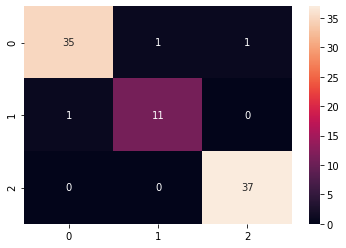

In [14]:
params = {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 10}
model_a = ensemble.RandomForestClassifier(**params, n_jobs=6, verbose=True)
model_a.fit(X_train, y_train)
predicted = model_a.predict(X_test)

#Medidas de rendimiento
print("Accuracy: %s" % metrics.balanced_accuracy_score(y_test, predicted))
print("Confusion matrix:")
sns.heatmap(metrics.confusion_matrix(y_test, predicted), annot=True)

In [15]:
pca = decomposition.PCA(n_components=2)
while 1:
    try:
        projected = pca.fit_transform(data)
    except:
        continue
    break

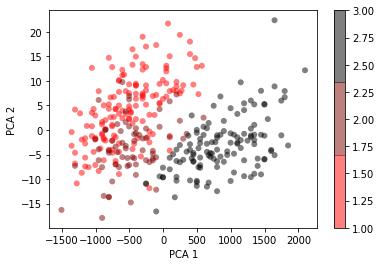

In [16]:
plt.scatter(projected[:, 0], projected[:, 1], c=data['species'], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('flag', 3))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()

Vamos a diferenciar la clase 3 de la 1 y 2.

In [17]:
species_p1 = {1:4, 2:4, 3:3}
p1_labels = data['species'].apply(lambda x: species_p1[x])
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(data[['island','culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex']], p1_labels, test_size=0.25)

model = ensemble.RandomForestClassifier(n_jobs=2, verbose=True)

param_grid = {'n_estimators': [10, 50, 100, 500, 1000],
             'criterion': ['gini', 'entropy'],
             'max_features': ['auto', 'sqrt', 'log2']}

scorer = metrics.make_scorer(metrics.balanced_accuracy_score, greater_is_better=True)

grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs=6, verbose=10)

grid_search.fit(data[['island','culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex']], p1_labels)
report(grid_search.cv_results_, n_top=6)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Batch computation too fast (0.0280s.) Setting batch_size=2.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done  42 out of  60 | elapsed:    3.1s remaining:    1.3s
[Parallel(n_jobs=6)]: Done  56 out of  60 | elapsed:    4.6s remaining:    0.2s


Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 10}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 500}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 1000}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 50}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 500}

Model with ran

[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    6.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy: 1.0
Confusion matrix:


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


<AxesSubplot:>

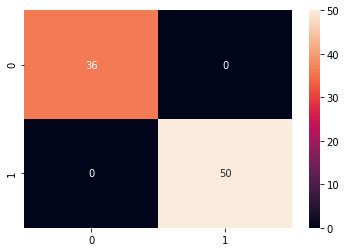

In [18]:
params = {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 10}
model_b = ensemble.RandomForestClassifier(**params, n_jobs=6, verbose=True)
model_b.fit(X_train, y_train)
predicted = model_b.predict(X_test)

#Medidas de rendimiento
print("Accuracy: %s" % metrics.balanced_accuracy_score(y_test, predicted))
print("Confusion matrix:")
sns.heatmap(metrics.confusion_matrix(y_test, predicted), annot=True)

In [19]:
data_1_2 = data.loc[data['species'] < 3]
data_1_2

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
Index,,,,,,,
0,1,1,39.1,18.7,181.0,3750.0,2.0
1,1,1,39.5,17.4,186.0,3800.0,1.0
2,1,1,40.3,18.0,195.0,3250.0,1.0
4,1,1,36.7,19.3,193.0,3450.0,1.0
5,1,1,39.3,20.6,190.0,3650.0,2.0
...,...,...,...,...,...,...,...
215,2,2,55.8,19.8,201.0,4000.0,2.0
216,2,2,43.5,18.1,202.0,3400.0,1.0
217,2,2,49.6,18.2,193.0,3775.0,2.0


In [20]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(data_1_2[['island','culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex']], data_1_2[['species']], test_size=0.25)

model = ensemble.RandomForestClassifier(n_jobs=2, verbose=True)

param_grid = {'n_estimators': [10, 50, 100, 500, 1000],
             'criterion': ['gini', 'entropy'],
             'max_features': ['auto', 'sqrt', 'log2']}

scorer = metrics.make_scorer(metrics.balanced_accuracy_score, greater_is_better=True)

grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs=6, verbose=10)

grid_search.fit(data_1_2[['island','culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex']], data_1_2[['species']])

report(grid_search.cv_results_, n_top=6)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Batch computation too fast (0.0290s.) Setting batch_size=2.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done  42 out of  60 | elapsed:    3.1s remaining:    1.3s
[Parallel(n_jobs=6)]: Done  56 out of  60 | elapsed:    4.5s remaining:    0.2s


Model with rank: 1
Mean validation score: 0.986 (std: 0.014)
Parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.985 (std: 0.015)
Parameters: {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 500}

Model with rank: 2
Mean validation score: 0.985 (std: 0.015)
Parameters: {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 1000}

Model with rank: 2
Mean validation score: 0.985 (std: 0.015)
Parameters: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100}

Model with rank: 5
Mean validation score: 0.982 (std: 0.018)
Parameters: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 1000}

Model with rank: 5
Mean validation score: 0.982 (std: 0.018)
Parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 50}



[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    5.8s finished
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy: 1.0
Confusion matrix:


<ipython-input-21-a9180cecb40d>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_c.fit(X_train, y_train)
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


<AxesSubplot:>

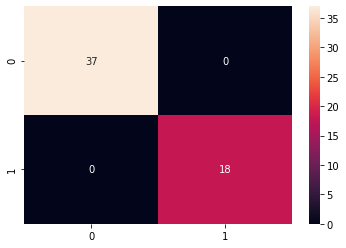

In [21]:
params = {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}
model_c = ensemble.RandomForestClassifier(**params, n_jobs=6, verbose=True)
model_c.fit(X_train, y_train)
predicted = model_c.predict(X_test)

#Medidas de rendimiento
print("Accuracy: %s" % metrics.balanced_accuracy_score(y_test, predicted))
print("Confusion matrix:")
sns.heatmap(metrics.confusion_matrix(y_test, predicted), annot=True)

probemos el rendimiento general

In [22]:
main_res = []
ensemble_res = []
for i in data.index.values:
    d = model_a.predict([data.loc[i,['island','culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex']]])
    main_res.append(d[0])
        
    d = model_b.predict([data.loc[i,['island','culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex']]])
    if d[0] == 3:
        ensemble_res.append(d[0])
    else:
        d = model_c.predict([data.loc[i,['island','culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g','sex']]])
        ensemble_res.append(d[0])
    
        

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)

[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBac

[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 

[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using b

[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using b

[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using b

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)

[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBac

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of 

[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using b

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)

[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using b

[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(

[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(

[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(

[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(

Accuracy: 0.9878922591344352
Confusion matrix:


<AxesSubplot:>

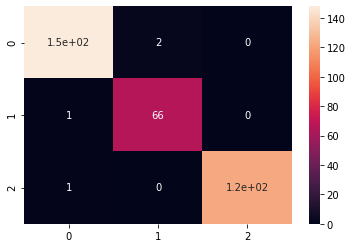

In [23]:
print("Accuracy: %s" % metrics.balanced_accuracy_score(main_res, data['species']))
print("Confusion matrix:")
sns.heatmap(metrics.confusion_matrix(main_res, data['species']), annot=True)

Accuracy: 1.0
Confusion matrix:


<AxesSubplot:>

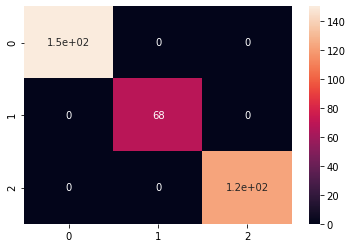

In [24]:
print("Accuracy: %s" % metrics.balanced_accuracy_score(ensemble_res, data['species']))
print("Confusion matrix:")
sns.heatmap(metrics.confusion_matrix(ensemble_res, data['species']), annot=True)

Como podemos ver, el modelo de prediccion jerarquica funciono mejor que el modelo unico. Esto puede ser debido a que el problema era un poco mas facil para cada uno de los submodelos. Sin embargo, la diferencia es tan poca, que perfectamente puede haber ocurrido que la partida inicial era un poco mejor en los modelo de la prediccion jerarquica y por es un un poco mejor. 